In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# CGS constants
G = 6.67430e-8          # cm^3 g^-1 s^-2
M_sun = 1.98847e33      # g
R_earth = 6.371e8       # cm

# Eq.(11) constants
m_e  = 9.10938356e-28
c    = 2.99792458e10
hbar = 1.054571817e-27
m_u  = 1.66053906660e-24
mu_e = 2.0

C_th = (m_e**4 * c**5) / (24*np.pi**2*hbar**3)
D_th = (mu_e*m_u*(m_e**3)*(c**3)) / (3*np.pi**2*hbar**3)

print("C_theory =", C_th)
print("D_theory =", D_th)

C_theory = 6.0023318237463825e+22
D_theory = 1947864.246154606


In [11]:
q = 3

def h_of_x(x):
    s = np.sqrt(1 + x*x)
    return x*(2*x*x - 3)*s + 3*np.arcsinh(x)

def dhdx(x):
    s = np.sqrt(1 + x*x)
    A = 2*x**3 - 3*x
    return (6*x*x - 3)*s + A*(x/s) + 3/s

def dPdrho(rho, C, D):
    if rho <= 0:
        return 0.0
    x = (rho/D)**(1/q)
    dxdrho = (1/q) * rho**(1/q - 1) * D**(-1/q)
    return C * dhdx(x) * dxdrho

In [12]:
def solve_star(rho_c, C, D, r_max=5e9):
    eps = 1e-2
    m0 = (4*np.pi/3)*rho_c*eps**3
    y0 = [m0, rho_c]

    rho_floor = rho_c*1e-10

    def rhs(r, y):
        m, rho = y
        if rho <= rho_floor:
            return [0.0, 0.0]
        dmdr = 4*np.pi*r*r*rho
        dPdr = -G*m*rho/(r*r)
        cs2  = dPdrho(rho, C, D)
        if cs2 <= 0:
            return [dmdr, 0.0]
        drhodr = dPdr/cs2
        return [dmdr, drhodr]

    def surface(r, y):
        return y[1] - rho_floor
    surface.terminal = True
    surface.direction = -1

    sol = solve_ivp(rhs, (eps, r_max), y0,
                    events=surface,
                    rtol=1e-7, atol=1e-9)

    if sol.t_events[0].size == 0:
        return None

    R = sol.t_events[0][0]
    M = sol.y_events[0][0][0]
    return R, M

In [13]:
rho_c_list = D_th * np.logspace(-4, 4, 120)

R_list = []
M_list = []

for rho_c in rho_c_list:
    out = solve_star(rho_c, C_th, D_th)
    if out is None:
        continue
    R, M = out
    R_list.append(R)
    M_list.append(M)

R_list = np.array(R_list)
M_list = np.array(M_list)

print("Computed models:", len(M_list))

Computed models: 92


M_max = 1.4406304071356821 Msun
R at M_max = 0.17025135130408775 R_earth


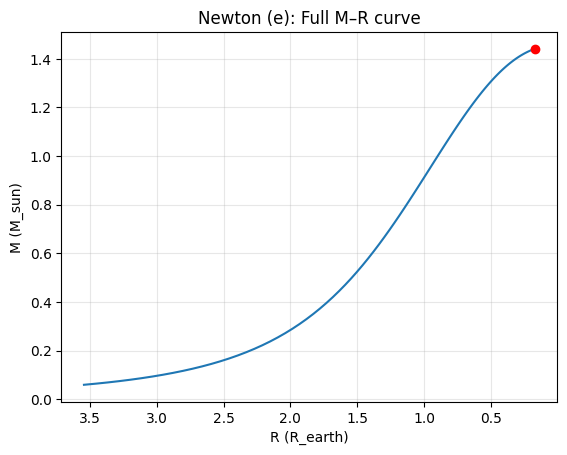

In [14]:
M_solar = M_list / M_sun
R_Re    = R_list / R_earth

idx = np.argmax(M_solar)
M_max = M_solar[idx]
R_at_Mmax = R_Re[idx]

print("M_max =", M_max, "Msun")
print("R at M_max =", R_at_Mmax, "R_earth")

plt.figure()
plt.plot(R_Re, M_solar, "-")
plt.scatter(R_at_Mmax, M_max, color="red", zorder=5)
plt.gca().invert_xaxis()
plt.xlabel("R (R_earth)")
plt.ylabel("M (M_sun)")
plt.title("Newton (e): Full M–R curve")
plt.grid(True, alpha=0.3)
plt.show()

In [15]:
# n = 3 polytrope Chandrasekhar mass
# M_Ch ≈ 5.83 / mu_e^2 Msun
M_Ch_theory = 5.83 / (mu_e**2)

print("M_Ch (theory) =", M_Ch_theory, "Msun")
print("M_max (numerical) =", M_max, "Msun")
print("ratio =", M_max / M_Ch_theory)

M_Ch (theory) = 1.4575 Msun
M_max (numerical) = 1.4406304071356821 Msun
ratio = 0.9884256652731953
